# Feature Engineering (Part 3)

This notebook constitutes the continuation of the feature enginnering process started in the previous notebook called *Feature Enginnering (Part 2)*.

#### 5.4 Word2Vec

*Word2Vec* is a trainning algorithm which uses a shallow neural network to represent the word embeddings (source: https://radimrehurek.com/gensim/models/word2vec.html). In contrary to the *Bag of Words* and *TF-IDF* which don't consider the order of the sentences, Word2Vec consider the synthax, the order of the sentences and the relationship between the words and their context of use. Therefore, we are going to try to use this algorithm to understand the relationship between the words and with which ones they are associated together.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Import specific libraries to work with "Word2Vec"
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors
import nltk
nltk.download('punkt') # Download the Punkt tokenizer
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the dataset with the raw reviews 
medication_reviews_dataset_raw= pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/Sentiment-Analysis-of-Medication-Reviews-Project/drugsComTrain_raw.tsv', sep='\t')
# medication_reviews_dataset_raw = pd.read_csv('/Users/rafaelaqueiroz/Sentiment-Analysis-of-Medication-Reviews-Project/drugsComTrain_raw.tsv', sep='\t')
medication_reviews_dataset_raw.head(3)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17


In [4]:
# Load the dataset with the reviews processed
medication_reviews_dataset_processed_df = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/Sentiment-Analysis-of-Medication-Reviews-Project/medication_reviews_dataset_to_train.csv', sep=',')
# medication_reviews_dataset_processed_df = pd.read_csv('/Users/rafaelaqueiroz/Sentiment-Analysis-of-Medication-Reviews-Project/medication_reviews_dataset_to_train.csv', sep=',')
medication_reviews_dataset_processed_df.head(3)

,drugName,condition,rating,date,usefulCount,year,review_word_lemm,polarity,rating_classification
0,Valsartan,Left Ventricular Dysfunction,9.0,2012-05-20,27,2012,"['no', 'side', 'effect', 'take', 'combination'...",0.000000,2
1,Guanfacine,ADHD,8.0,2010-04-27,192,2010,"['son', 'halfway', 'fourth', 'week', 'intuniv'...",0.188021,2
2,Lybrel,Birth Control,5.0,2009-12-14,17,2009,"['used', 'take', 'another', 'oral', 'contracep...",0.113636,1


First, we are going to analyze how many words are used per review just to get an average of the vocabulary used and the reviews lenght afterwards.

In [9]:
# Calculate the total number of words in each review
reviews = medication_reviews_dataset_processed_df['review_word_lemm']

word_counts = []

for review in reviews:
    word_count = len(review)
    word_counts.append(word_count)

print(f"The number of words in each review is: {word_counts}")

The number of words in each review is: [80, 616, 674, 360, 634, 442, 136, 616, 205, 693, 589, 429, 356, 509, 691, 617, 640, 624, 687, 397, 481, 561, 385, 661, 128, 396, 699, 639, 430, 676, 30, 251, 324, 95, 112, 52, 339, 114, 620, 307, 188, 646, 201, 109, 632, 378, 374, 113, 610, 238, 609, 119, 372, 157, 103, 1935, 402, 557, 115, 419, 325, 463, 261, 474, 555, 597, 353, 495, 27, 373, 582, 497, 74, 382, 174, 260, 223, 518, 417, 635, 775, 500, 317, 357, 718, 79, 431, 703, 523, 312, 204, 663, 632, 579, 652, 512, 450, 588, 592, 648, 463, 635, 284, 634, 136, 624, 199, 163, 364, 229, 271, 309, 308, 403, 340, 675, 478, 370, 422, 568, 609, 677, 516, 220, 293, 338, 493, 572, 723, 401, 193, 622, 704, 99, 592, 592, 392, 593, 614, 381, 321, 700, 167, 196, 615, 16, 625, 636, 27, 356, 507, 220, 634, 386, 526, 391, 685, 355, 376, 388, 482, 209, 509, 640, 392, 273, 299, 319, 569, 518, 434, 618, 180, 177, 56, 280, 260, 586, 606, 332, 27, 609, 186, 236, 732, 641, 371, 492, 204, 178, 576, 188, 724, 78, 47

In [10]:
# Calculate the total number of reviews
total_reviews = len(medication_reviews_dataset_processed_df)
total_reviews

112329

In [11]:
# Let's sum the word count
total_word_count = sum(word_counts)
print(f"The total number of words in all reviews is: {total_word_count}")

The total number of words in all reviews is: 45319513


In [12]:
# Calculate the average number of words per review
avg_words_per_review = total_word_count / total_reviews

print(f"Total number of words: {total_word_count}")
print(f"Total number of reviews: {total_reviews}")
print(f"Average number of words per review: {avg_words_per_review}")

Total number of words: 45319513
Total number of reviews: 112329
Average number of words per review: 403.4533646698537


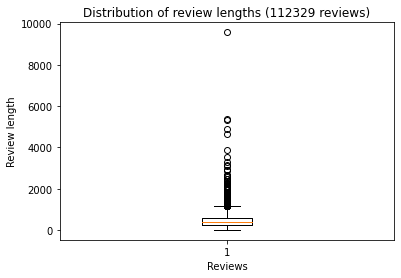

In [20]:
# Let's see the results and if there are any outliers considering the average length

# Define the review lengths
review_lengths = [len(review) for review in medication_reviews_dataset_processed_df.review_word_lemm]

# Plot the distribution of the review lengths as a box plot
plt.boxplot(review_lengths)
plt.xlabel("Reviews")
plt.ylabel("Review length")
plt.title(f"Distribution of review lengths ({total_reviews} reviews)")
plt.show()

In [24]:
# Let's convert the reviews back to strings
vectorizer_input = medication_reviews_dataset_processed_df['review_word_lemm'].apply(lambda x: "".join(x))
vectorizer_input

0         ['no', 'side', 'effect', 'take', 'combination'...
1         ['son', 'halfway', 'fourth', 'week', 'intuniv'...
2         ['used', 'take', 'another', 'oral', 'contracep...
3         ['first', 'time', 'using', 'form', 'birth', 'c...
4         ['suboxone', 'completely', 'turned', 'life', '...
                                ...                        
112324    ['mg', 'seems', 'work', 'every', 'nd', 'day', ...
112325    ['tekturna', 'day', 'effect', 'immediate', 'al...
112326    ['wrote', 'first', 'report', 'midoctober', 'no...
112327    ['ive', 'thyroid', 'medication', 'year', 'spen...
112328    ['ive', 'chronic', 'constipation', 'adult', 'l...
Name: review_word_lemm, Length: 112329, dtype: object

In [25]:
print(type(vectorizer_input[0]))

<class 'str'>


In [26]:
print(type(vectorizer_input[1900]))

<class 'str'>


In [27]:
first_review = medication_reviews_dataset_processed_df['review_word_lemm'][0]
print(type(first_review))

<class 'str'>


In [32]:
# Create an instance of the CountVectorizer with the bigram configuration
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform the training data to extract bigrams
X_train_bigrams = vectorizer.fit_transform(vectorizer_input)

# Get the feature names (i.e., the bigrams)
bigram_names = vectorizer.get_feature_names_out()
print(bigram_names[:20])

['aa alcohol' 'aa begin' 'aa believe' 'aa campral' 'aa cannot'
 'aa completely' 'aa counseling' 'aa counselling' 'aa cup' 'aa didnt'
 'aa doctor' 'aa dont' 'aa drinking' 'aa due' 'aa etc' 'aa extremely'
 'aa found' 'aa gave' 'aa getting' 'aa given']


In [21]:
# Get the values of the reviews (the raw reviews)
reviews_values = medication_reviews_dataset_raw['review'].values
reviews_values

array(['"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
       '"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."',
       '"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But 

In [22]:
reviews_vec = [nltk.word_tokenize(review) for review in reviews_values]

In [23]:
print(reviews_vec[1])

['``', 'My', 'son', 'is', 'halfway', 'through', 'his', 'fourth', 'week', 'of', 'Intuniv', '.', 'We', 'became', 'concerned', 'when', 'he', 'began', 'this', 'last', 'week', ',', 'when', 'he', 'started', 'taking', 'the', 'highest', 'dose', 'he', 'will', 'be', 'on', '.', 'For', 'two', 'days', ',', 'he', 'could', 'hardly', 'get', 'out', 'of', 'bed', ',', 'was', 'very', 'cranky', ',', 'and', 'slept', 'for', 'nearly', '8', 'hours', 'on', 'a', 'drive', 'home', 'from', 'school', 'vacation', '(', 'very', 'unusual', 'for', 'him', '.', ')', 'I', 'called', 'his', 'doctor', 'on', 'Monday', 'morning', 'and', 'she', 'said', 'to', 'stick', 'it', 'out', 'a', 'few', 'days', '.', 'See', 'how', 'he', 'did', 'at', 'school', ',', 'and', 'with', 'getting', 'up', 'in', 'the', 'morning', '.', 'The', 'last', 'two', 'days', 'have', 'been', 'problem', 'free', '.', 'He', 'is', 'MUCH', 'more', 'agreeable', 'than', 'ever', '.', 'He', 'is', 'less', 'emotional', '(', 'a', 'good', 'thing', ')', ',', 'less', 'cranky', '.

### Word2Vec with Continuous Bag of Words (CBOW)

In [24]:
# Create the model by using the CBOW first
# In the window size, we are considering 2 words before and after
# In the min_count, we decided to stck with at least 1 occurence of each word, as the appearance of only one positive or negative can give us some clues about the sentiment of the user
model_reviews_cbow = Word2Vec(reviews_vec, min_count=1, window=2)

In [25]:
# Save the model to the disk
model_reviews_cbow.save("word2vec_cbow.model")

In [26]:
# What are the most similar words to a especific given word that appears in the review?
model_reviews_cbow.wv.most_similar('negative', topn=15)

[('positive', 0.8254463076591492),
 ('adverse', 0.6248674988746643),
 ('negatives', 0.5958167314529419),
 ('horror', 0.5808703303337097),
 ('neg', 0.5785373449325562),
 ('scary', 0.5715237259864807),
 ('terrifying', 0.5493531823158264),
 ('unpleasant', 0.5395267009735107),
 ('warnings', 0.5356982350349426),
 ('side', 0.5345538854598999),
 ('near-puke', 0.5258655548095703),
 ('positives', 0.5216841697692871),
 ('strange', 0.5176272392272949),
 ('disturbing', 0.5166948437690735),
 ('dramatic', 0.5165404677391052)]

In [27]:
model_reviews_cbow.wv.most_similar('positive', topn=15)

[('negative', 0.8254464268684387),
 ('dramatic', 0.6876177787780762),
 ('favorable', 0.6089335680007935),
 ('drastic', 0.5915243029594421),
 ('subtle', 0.584355354309082),
 ('remarkable', 0.574733555316925),
 ('unpleasant', 0.5651459693908691),
 ('beneficial', 0.5618982315063477),
 ('interesting', 0.5553228855133057),
 ('gradual', 0.5457451343536377),
 ('welcome', 0.5437253713607788),
 ('scary', 0.541144073009491),
 ('pleasant', 0.5386195182800293),
 ('noticeable', 0.5336403250694275),
 ('good', 0.5311681032180786)]

In [28]:
model_reviews_cbow.wv.most_similar('body', topn=15)

[('head', 0.7064709067344666),
 ('face', 0.6786571145057678),
 ('vagina', 0.6757377982139587),
 ('uterus', 0.6669268012046814),
 ('brain', 0.6558262705802917),
 ('vag', 0.6153714060783386),
 ('system', 0.6099754571914673),
 ('skin', 0.6095615029335022),
 ('tongue', 0.6040387749671936),
 ('nerves', 0.6026427745819092),
 ('gut', 0.5974752306938171),
 ('eyesight', 0.5856532454490662),
 ('cervix', 0.5778198838233948),
 ('stomach', 0.5765381455421448),
 ('penis', 0.5762868523597717)]

In [29]:
model_reviews_cbow.wv.most_similar('effect', topn=15)

[('effects', 0.735427737236023),
 ('affects', 0.6779669523239136),
 ('side-effect', 0.6429246068000793),
 ('affect', 0.6378794312477112),
 ('benefit', 0.6322107315063477),
 ('infects', 0.5940303206443787),
 ('effects-mostly', 0.593837559223175),
 ('effecet', 0.5866129398345947),
 ('T-boned', 0.5856193900108337),
 ('Effect', 0.58436119556427),
 ('effec', 0.5820870995521545),
 ('adoration', 0.5805656909942627),
 ('effects/symptoms', 0.5747858881950378),
 ('efects', 0.5741216540336609),
 ('effectSo', 0.5718619227409363)]

In [30]:
model_reviews_cbow.wv.most_similar('pill', topn=15)

[('medication', 0.8202125430107117),
 ('medicine', 0.8097191452980042),
 ('med', 0.7826932072639465),
 ('drug', 0.724643349647522),
 ('product', 0.663971483707428),
 ('patch', 0.6614229679107666),
 ('shot', 0.6568863391876221),
 ('BC', 0.6568557024002075),
 ('pills', 0.6492902040481567),
 ('tablet', 0.6473833322525024),
 ('implant', 0.6094107627868652),
 ('birth', 0.5990309715270996),
 ('stuff', 0.5980739593505859),
 ('antibiotic', 0.5891493558883667),
 ('Pill', 0.5741094946861267)]

In [31]:
model_reviews_cbow.wv.most_similar('happy', topn=15)

[('unhappy', 0.8122991323471069),
 ('pleased', 0.800875723361969),
 ('satisfied', 0.7947569489479065),
 ('thrilled', 0.7941291332244873),
 ('impressed', 0.7499977946281433),
 ('disappointed', 0.7338753342628479),
 ('optimistic', 0.7237792611122131),
 ('hopeful', 0.7214759588241577),
 ('blessed', 0.7201694250106812),
 ('excited', 0.711264967918396),
 ('delighted', 0.6952854990959167),
 ('sorry', 0.6820407509803772),
 ('proud', 0.6814546585083008),
 ('content', 0.6773796081542969),
 ('confident', 0.6737337708473206)]

In [32]:
model_reviews_cbow.wv.most_similar('sad', topn=15)

[('angry', 0.8102901577949524),
 ('paranoid', 0.8017252087593079),
 ('anxious', 0.7949790954589844),
 ('confused', 0.7850127220153809),
 ('depressed', 0.7823858261108398),
 ('moody', 0.7644615173339844),
 ('stressed', 0.7517059445381165),
 ('grumpy', 0.7425876259803772),
 ('lazy', 0.7422599196434021),
 ('mad', 0.7228055596351624),
 ('cranky', 0.7185295224189758),
 ('agitated', 0.7180012464523315),
 ('frustrated', 0.7051190137863159),
 ('fatigued', 0.7022863030433655),
 ('hopeless', 0.7004556655883789)]

In [33]:
model_reviews_cbow.wv.most_similar('good', topn=15)

[('great', 0.8264932632446289),
 ('wonderful', 0.6956437230110168),
 ('crappy', 0.6903713941574097),
 ('decent', 0.6855815649032593),
 ('fantastic', 0.6690157055854797),
 ('bad', 0.6624506711959839),
 ('strange', 0.6560753583908081),
 ('nice', 0.6489090323448181),
 ('perfect', 0.647922694683075),
 ('funny', 0.6435679197311401),
 ('okay', 0.6394365429878235),
 ('scary', 0.6332260966300964),
 ('awesome', 0.6147692203521729),
 ('terrific', 0.6145768165588379),
 ('strong', 0.6141512393951416)]

In [34]:
model_reviews_cbow.wv.most_similar('bad', topn=15)

[('terrible', 0.7371613383293152),
 ('badly', 0.7267322540283203),
 ('horrible', 0.7127596735954285),
 ('intense', 0.707521915435791),
 ('scary', 0.7025539875030518),
 ('severe', 0.6955479979515076),
 ('strange', 0.6895334124565125),
 ('weird', 0.681855320930481),
 ('awful', 0.6763375401496887),
 ('serious', 0.6706556081771851),
 ('nasty', 0.6699403524398804),
 ('good', 0.6624506711959839),
 ('depressing', 0.6462838649749756),
 ('horrendous', 0.6432353854179382),
 ('strong', 0.6336579918861389)]

In [35]:
word_vector_difference_1 = model_reviews_cbow.wv['bad'] - model_reviews_cbow.wv['good'] + model_reviews_cbow.wv['effect']
model_reviews_cbow.wv.most_similar([word_vector_difference_1])

[('effect', 0.7940628528594971),
 ('effects', 0.5494257211685181),
 ('optical', 0.5446865558624268),
 ('issue', 0.5230461955070496),
 ('side-effect', 0.5029807090759277),
 ('face/right', 0.48952776193618774),
 ('sensation', 0.4878554940223694),
 ('affect', 0.48234111070632935),
 ('affects', 0.47546619176864624),
 ('bad', 0.4727078974246979)]

In [36]:
word_vector_difference_2 = model_reviews_cbow.wv['good'] - model_reviews_cbow.wv['bad'] + model_reviews_cbow.wv['effect']
model_reviews_cbow.wv.most_similar([word_vector_difference_2])

[('effect', 0.7573935985565186),
 ('effects', 0.594123125076294),
 ('affects', 0.5810379981994629),
 ('infects', 0.5234634876251221),
 ('benefit', 0.5129514932632446),
 ('effects/withdrawal', 0.5100094079971313),
 ('affect', 0.5090957880020142),
 ('effec', 0.4972867965698242),
 ('effecet', 0.49680647253990173),
 ('side-effect', 0.4950487017631531)]

In [37]:
word_vector_difference_3 = model_reviews_cbow.wv['sad'] - model_reviews_cbow.wv['happy'] + model_reviews_cbow.wv['pill']
model_reviews_cbow.wv.most_similar([word_vector_difference_3])

[('pill', 0.7868321537971497),
 ('medication', 0.6135372519493103),
 ('medicine', 0.6100016832351685),
 ('med', 0.5848559141159058),
 ('tablet', 0.541802704334259),
 ('drug', 0.5412926077842712),
 ('shot', 0.4933513104915619),
 ('pills', 0.49239814281463623),
 ('implant', 0.48047617077827454),
 ('patch', 0.4777151048183441)]

In [38]:
word_vector_difference_4 = model_reviews_cbow.wv['happy'] - model_reviews_cbow.wv['sad'] + model_reviews_cbow.wv['body']
model_reviews_cbow.wv.most_similar([word_vector_difference_4], topn=15) # The topn parameter is get other similar words

[('body', 0.7521106600761414),
 ('face', 0.5799744129180908),
 ('VAGAY', 0.544750988483429),
 ('vagina', 0.5427913069725037),
 ('happy', 0.5334592461585999),
 ('skin', 0.5187343955039978),
 ('uterus', 0.5172330737113953),
 ('head', 0.5117644667625427),
 ('cervix', 0.5093852877616882),
 ('vag', 0.5075264573097229),
 ('nerves', 0.5074379444122314),
 ('system', 0.5046239495277405),
 ('ESTRING', 0.49390870332717896),
 ('life', 0.49071455001831055),
 ('spouse', 0.4824245572090149)]

In [39]:
# How the words are represented in the vector dimensional space?
model_reviews_cbow.wv['good'] # It gets a numpy vector of a word

array([-0.01211055,  0.71030194,  0.60989106,  1.2129608 ,  0.40176836,
       -0.42915392, -0.1391216 , -0.5251095 , -0.79174227, -0.0682982 ,
       -1.5364505 , -0.3347619 , -0.73397064,  2.2991998 , -0.46684387,
       -0.14333534,  0.11357246, -0.40520668,  1.2844126 ,  0.212428  ,
        0.42718643,  0.00794191, -0.9020946 , -1.692741  ,  1.2987912 ,
       -1.444321  ,  0.32891223, -0.79007363, -0.95948076,  0.41546607,
       -0.99547106, -1.4995642 ,  0.8065801 ,  1.8895504 ,  1.6483732 ,
        2.2441661 , -0.32913807, -0.8662885 ,  0.02541744,  1.0104711 ,
       -1.1215738 ,  2.7727232 , -1.7667584 , -1.783916  ,  1.1544762 ,
        0.7001166 , -1.4591967 ,  2.53983   , -2.1169324 ,  0.6300496 ,
       -0.35608965, -0.17182554, -2.9032958 , -1.5805435 ,  0.77089405,
       -0.6653082 , -1.5396768 , -1.5709906 ,  2.0901577 ,  1.1566087 ,
       -0.5250195 ,  0.01105421,  0.30686694, -0.6171862 , -0.02190389,
        1.6975875 , -0.8355391 , -0.24474688, -2.046522  , -0.79

### Word2Vec with Skip Gram

In [40]:
# Create the model by using the Skip Gram (obs: notice sg parameter)
# In the window size, we are still considering 2 words before and after
model_reviews_sg = Word2Vec(reviews_vec, min_count=1, window=2, sg=1)

In [41]:
# Save the model to the disk
model_reviews_sg.save("word2vec_sg.model")

In [42]:
# What are the most similar words to a especific given word that appears in the review?
model_reviews_sg.wv.most_similar('negative', topn=15)

[('positive', 0.8350475430488586),
 ('neg', 0.7601006031036377),
 ('notable', 0.6715864539146423),
 ('negatives', 0.6623229384422302),
 ('worrisome', 0.6502823233604431),
 ('nightmarish', 0.6499717235565186),
 ('warnings', 0.6490187048912048),
 ('detrimental', 0.646469235420227),
 ('undesirable', 0.637852132320404),
 ('unwelcome', 0.6282626986503601),
 ('positives', 0.6261314153671265),
 ('scary', 0.6246140599250793),
 ('adverse', 0.622776448726654),
 ('unrealistic', 0.6213761568069458),
 ('horror', 0.6154811978340149)]

In [43]:
model_reviews_sg.wv.most_similar('positive', topn=15)

[('negative', 0.8350474834442139),
 ('neg', 0.6886979937553406),
 ('favorable', 0.6748619079589844),
 ('dramatic', 0.6479483842849731),
 ('optimistic', 0.638104259967804),
 ('upbeat', 0.6378485560417175),
 ('notable', 0.6376731395721436),
 ('drastic', 0.6337196826934814),
 ('remarkable', 0.6269606351852417),
 ('rational', 0.6236324310302734),
 ('confident', 0.6149887442588806),
 ('profound', 0.6133578419685364),
 ('POSITIVE', 0.6124441623687744),
 ('happy', 0.6120714545249939),
 ('fortunate', 0.6066337823867798)]

In [44]:
model_reviews_sg.wv.most_similar('body', topn=15)

[('head', 0.7354488372802734),
 ('face', 0.6744544506072998),
 ('chemistry', 0.6701171398162842),
 ('system', 0.6654579639434814),
 ('brain', 0.6498731374740601),
 ('bodies', 0.6435085535049438),
 ('skin', 0.636004626750946),
 ('senses', 0.6354045867919922),
 ('mind', 0.6270490884780884),
 ('limbs', 0.6237504482269287),
 ('mindset', 0.6135016083717346),
 ('skins', 0.6124199032783508),
 ('belly', 0.6120719909667969),
 ('vibrating', 0.6081333160400391),
 ('vagina', 0.6033351421356201)]

In [45]:
model_reviews_sg.wv.most_similar('effect', topn=15)

[('effects', 0.8145638108253479),
 ('affects', 0.779285728931427),
 ('side-effect', 0.7619746923446655),
 ('affect', 0.7413531541824341),
 ('drawback', 0.7102975249290466),
 ('downer', 0.7061589956283569),
 ('effect-', 0.6931715607643127),
 ('benefit', 0.6842995882034302),
 ('downside', 0.6833591461181641),
 ('downfall', 0.6796853542327881),
 ('effects-', 0.6745284795761108),
 ('issue', 0.6666358709335327),
 ('effects/', 0.6662503480911255),
 ('criticism', 0.664624810218811),
 ('con', 0.6631050705909729)]

In [46]:
model_reviews_sg.wv.most_similar('pill', topn=15)

[('pills', 0.7817943096160889),
 ('med', 0.7645567655563354),
 ('medication', 0.7597237229347229),
 ('medicine', 0.748971700668335),
 ('birthcontrol', 0.7287055850028992),
 ('tablet', 0.7273815274238586),
 ('Aubra', 0.7210901379585266),
 ('BC', 0.7196241617202759),
 ('orsythia', 0.714763879776001),
 ('BCP', 0.7107940912246704),
 ('bc', 0.7068148851394653),
 ('pil', 0.7065548896789551),
 ('drug', 0.7056823968887329),
 ('birth-control', 0.7023303508758545),
 ('Pill', 0.7014557123184204)]

In [47]:
model_reviews_sg.wv.most_similar('happy', topn=15)

[('pleased', 0.8371984362602234),
 ('satisfied', 0.8322616815567017),
 ('optimistic', 0.8118736147880554),
 ('thrilled', 0.7978255152702332),
 ('unhappy', 0.7888447046279907),
 ('blessed', 0.7854103446006775),
 ('hopeful', 0.7720242738723755),
 ('impressed', 0.7698571681976318),
 ('overjoyed', 0.7682238221168518),
 ('excited', 0.7622311115264893),
 ('content', 0.7578367590904236),
 ('delighted', 0.7572414875030518),
 ('loving', 0.7528533339500427),
 ('upbeat', 0.7526414394378662),
 ('exited', 0.7492988109588623)]

In [48]:
model_reviews_cbow.wv.most_similar('sad', topn=15)

[('angry', 0.8102901577949524),
 ('paranoid', 0.8017252087593079),
 ('anxious', 0.7949790954589844),
 ('confused', 0.7850127220153809),
 ('depressed', 0.7823858261108398),
 ('moody', 0.7644615173339844),
 ('stressed', 0.7517059445381165),
 ('grumpy', 0.7425876259803772),
 ('lazy', 0.7422599196434021),
 ('mad', 0.7228055596351624),
 ('cranky', 0.7185295224189758),
 ('agitated', 0.7180012464523315),
 ('frustrated', 0.7051190137863159),
 ('fatigued', 0.7022863030433655),
 ('hopeless', 0.7004556655883789)]

In [49]:
model_reviews_cbow.wv.most_similar('good', topn=15)

[('great', 0.8264932632446289),
 ('wonderful', 0.6956437230110168),
 ('crappy', 0.6903713941574097),
 ('decent', 0.6855815649032593),
 ('fantastic', 0.6690157055854797),
 ('bad', 0.6624506711959839),
 ('strange', 0.6560753583908081),
 ('nice', 0.6489090323448181),
 ('perfect', 0.647922694683075),
 ('funny', 0.6435679197311401),
 ('okay', 0.6394365429878235),
 ('scary', 0.6332260966300964),
 ('awesome', 0.6147692203521729),
 ('terrific', 0.6145768165588379),
 ('strong', 0.6141512393951416)]

In [50]:
model_reviews_cbow.wv.most_similar('bad', topn=15)

[('terrible', 0.7371613383293152),
 ('badly', 0.7267322540283203),
 ('horrible', 0.7127596735954285),
 ('intense', 0.707521915435791),
 ('scary', 0.7025539875030518),
 ('severe', 0.6955479979515076),
 ('strange', 0.6895334124565125),
 ('weird', 0.681855320930481),
 ('awful', 0.6763375401496887),
 ('serious', 0.6706556081771851),
 ('nasty', 0.6699403524398804),
 ('good', 0.6624506711959839),
 ('depressing', 0.6462838649749756),
 ('horrendous', 0.6432353854179382),
 ('strong', 0.6336579918861389)]

### Pre-trained Word2Vec Model: *GoogleNews*

In [ ]:
# Try the pre-trained "google_news_300" model
import gensim.downloader as api
google_news_300 = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# google_news_300 = KeyedVectors.load_word2vec_format('user path', binary=True, limit=100000)

In [ ]:
google_news_300['positive']

array([ 3.26538086e-03, -7.95898438e-02,  1.02539062e-01, -2.05078125e-01,
       -1.44531250e-01, -1.58203125e-01, -1.34887695e-02,  7.56835938e-02,
        1.25976562e-01,  3.06640625e-01, -1.80664062e-01, -7.32421875e-02,
        3.33984375e-01,  3.20312500e-01, -1.07910156e-01,  9.66796875e-02,
        1.01562500e-01,  1.96289062e-01,  3.97949219e-02, -1.75781250e-02,
        3.49121094e-02,  3.67187500e-01, -7.91015625e-02, -4.27246094e-02,
        6.92749023e-03,  1.66015625e-02, -4.15039062e-02,  2.53906250e-02,
        2.73437500e-01,  1.33789062e-01, -1.52343750e-01, -2.91015625e-01,
       -2.08740234e-02, -1.07910156e-01,  6.22558594e-02,  7.51953125e-02,
       -1.61132812e-01,  1.00097656e-01, -1.07910156e-01, -2.17773438e-01,
        5.78613281e-02, -2.44140625e-02,  5.68847656e-02,  2.21679688e-01,
       -1.03515625e-01, -1.65039062e-01,  3.12500000e-02, -7.32421875e-02,
       -3.52478027e-03, -5.83496094e-02,  1.19628906e-01, -9.81445312e-02,
       -1.60156250e-01,  